In [ ]:
# === Cell 1: Import Libraries === #

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from itertools import product
from scipy.optimize import minimize




print("Libraries imported.")

Libraries imported.


In [47]:
# === Cell 2: Load Training Data === #

# Define the path to the dataset
TRAINING_FILE_PATH = "C:\\Users\\aaash\\OneDrive\\Desktop\\ML_MIDSEM\\Training_dataset.xlsx" 

# Check file extension to use the correct pandas reader
if TRAINING_FILE_PATH.lower().endswith(".xlsx"):
    training_data = pd.read_excel(TRAINING_FILE_PATH)
else:
    training_data = pd.read_csv(TRAINING_FILE_PATH)

print(f"Training data loaded successfully. Shape: {training_data.shape}")
training_data.head()

Training data loaded successfully. Shape: (698, 10)


,ID,X1,X2,X3,X4,X5,X6,X7,X8,Y1
0,1,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,2,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,3,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,4,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,5,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84


In [48]:
# === Cell 3: Data Structure Overview === #

# Get a quick overview of column names, counts, and data types

training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      698 non-null    int64  
 1   X1      698 non-null    float64
 2   X2      698 non-null    float64
 3   X3      698 non-null    float64
 4   X4      698 non-null    float64
 5   X5      698 non-null    float64
 6   X6      698 non-null    int64  
 7   X7      698 non-null    float64
 8   X8      698 non-null    int64  
 9   Y1      698 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 54.7 KB


In [49]:
# === Cell 4: Check Value Counts === #

print("Checking Value Counts")
# Loop through columns to check for cardinality and missing values 
for column in training_data.columns:
    value_counts_top10 = training_data[column].value_counts(dropna=False).head(10)
    print(f"\nColumn: {column}")
    print(value_counts_top10)

Checking Value Counts

Column: ID
ID
698    1
1      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
Name: count, dtype: int64

Column: X1
X1
0.98    60
0.90    60
0.86    60
0.82    60
0.79    60
0.76    60
0.74    58
0.71    56
0.69    56
0.66    56
Name: count, dtype: int64

Column: X2
X2
514.5    60
563.5    60
588.0    60
612.5    60
637.0    60
661.5    60
686.0    58
710.5    56
735.0    56
759.5    56
Name: count, dtype: int64

Column: X3
X3
294.0    176
318.5    176
343.0    116
416.5     60
245.0     58
269.5     56
367.5     56
Name: count, dtype: int64

Column: X4
X4
220.50    338
147.00    180
122.50    120
110.25     60
Name: count, dtype: int64

Column: X5
X5
7.0    360
3.5    338
Name: count, dtype: int64

Column: X6
X6
2    175
3    175
4    174
5    174
Name: count, dtype: int64

Column: X7
X7
0.10    240
0.25    240
0.40    170
0.00     48
Name: count, dtype: int64

Column: X8
X8
1    144
2    144
3    144
4    122
5     96
0     48
Name: co

In [50]:
# === Cell 5: Summary Statistics === #

# Get a statistical summary (mean, std, percentiles) for all columns
# .T transposes the output to make it easier to read
training_data.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
ID,698.0,349.500000,201.639530,1.00,175.2500,349.50,523.750,698.00
X1,698.0,0.767106,0.105898,0.62,0.6900,0.76,0.860,0.98
X2,698.0,669.151862,87.988814,514.50,588.0000,661.50,735.000,808.50
X3,698.0,318.710602,43.743818,245.00,294.0000,318.50,343.000,416.50
X4,698.0,175.220630,45.186276,110.25,122.5000,147.00,220.500,220.50
X5,698.0,5.305158,1.750385,3.50,3.5000,7.00,7.000,7.00
X6,698.0,3.497135,1.118832,2.00,2.2500,3.00,4.000,5.00
X7,698.0,0.217765,0.128448,0.00,0.1000,0.25,0.250,0.40
X8,698.0,2.624642,1.495884,0.00,1.0000,3.00,4.000,5.00
Y1,698.0,22.319908,10.127774,6.01,12.8875,19.60,31.655,43.10


In [ ]:
# === Cell 6: Identify Column Roles === #

# Target Column Identification 
#Search for common target names
COMMON_TARGET_NAMES = ['heating_load', 'y1', 'target']
target_column = None

for column in training_data.columns:
    if str(column).strip().lower() in COMMON_TARGET_NAMES:
        target_column = column
        break

# If no common name is found, assume the last column is the target
if target_column is None:
    target_column = training_data.columns[-1]

# --- ID Column Identification ---
COMMON_ID_NAMES = ['id','index','row_id','unnamed: 0','sample_id']
id_columns = []
for column in training_data.columns:
    clean_column_name = str(column).strip().lower()
    if clean_column_name in COMMON_ID_NAMES:
        id_columns.append(column)

print(f"Target Column Identified: {target_column}")
print(f"ID-like Columns Identified: {id_columns if id_columns else 'None'}")

# --- Feature Column Identification ---
# Separate columns by data type
numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = training_data.select_dtypes(include=['object','category']).columns.tolist()

# Features are everything that isn't an ID or the target
feature_columns = [c for c in training_data.columns if c not in id_columns + [target_column]]
print(f"Total Feature Columns: {len(feature_columns)}")

Target Column Identified: Y1
ID-like Columns Identified: ['ID']
Total Feature Columns: 8


In [52]:
# === Cell 7: Check Missing Values & Duplicates === #

print("--- Missing Values Per Column ---")
print(training_data.isnull().sum())

duplicate_rows = training_data.duplicated().sum()
print(f"\nTotal Duplicate Rows: {duplicate_rows}")

# Also check if any of our ID columns have duplicate entries
if id_columns:
    for id_col in id_columns:
        print(f"Duplicate IDs in {id_col}:", training_data[id_col].duplicated().sum())

--- Missing Values Per Column ---
ID    0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
dtype: int64

Total Duplicate Rows: 0
Duplicate IDs in ID: 0



--- Plotting Numeric Distributions ---


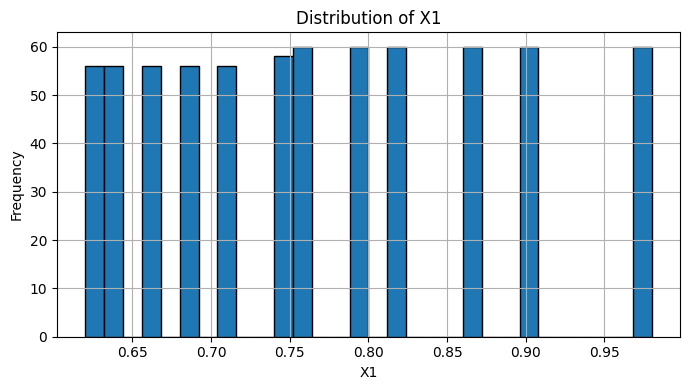

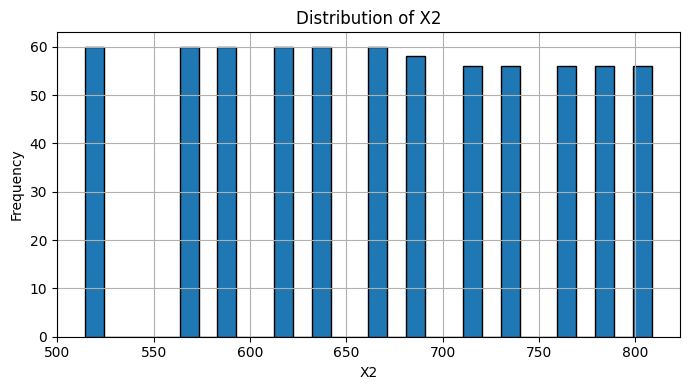

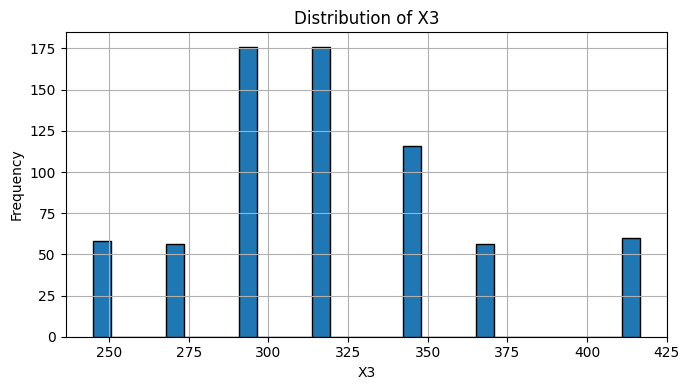

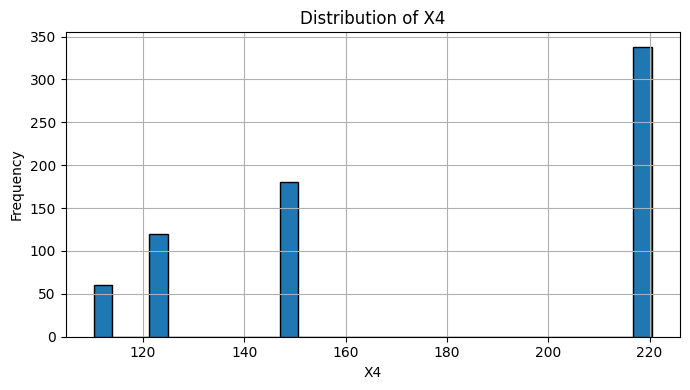

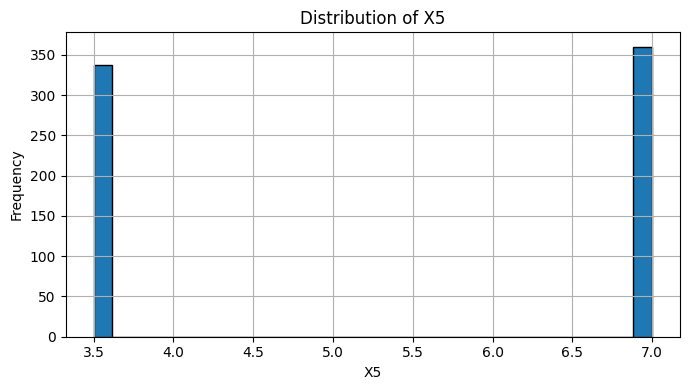

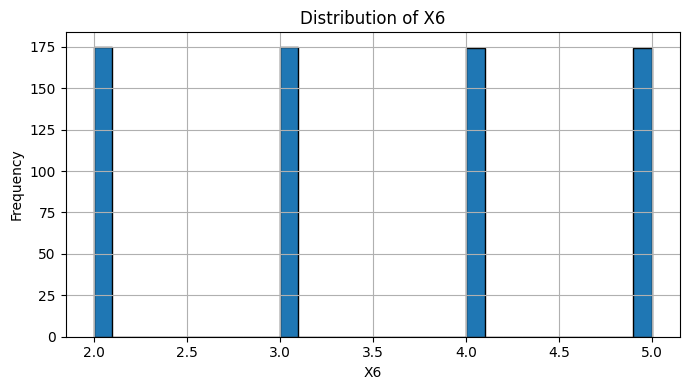

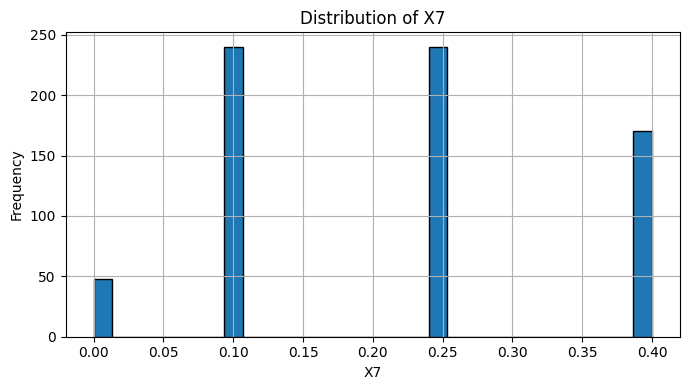

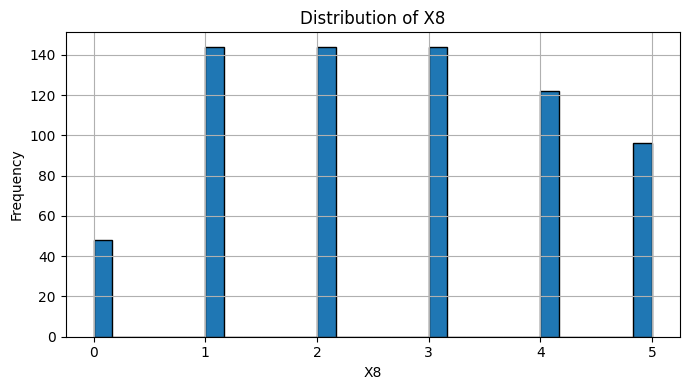

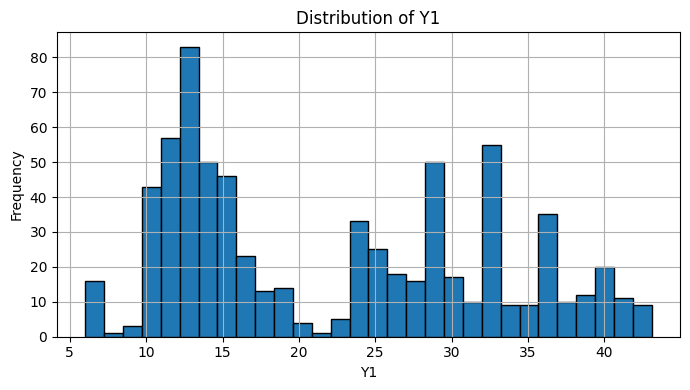

In [53]:
# === Cell 8: Visualize Numeric Distributions === #

print("\n--- Plotting Numeric Distributions ---")
# Plot histograms for all numeric columns to check for skew or outliers
for column in numeric_columns:
    # Skip ID columns in plots
    if column in id_columns:
        continue
        
    plt.figure(figsize=(7, 4))
    training_data[column].hist(bins=30, edgecolor='black')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

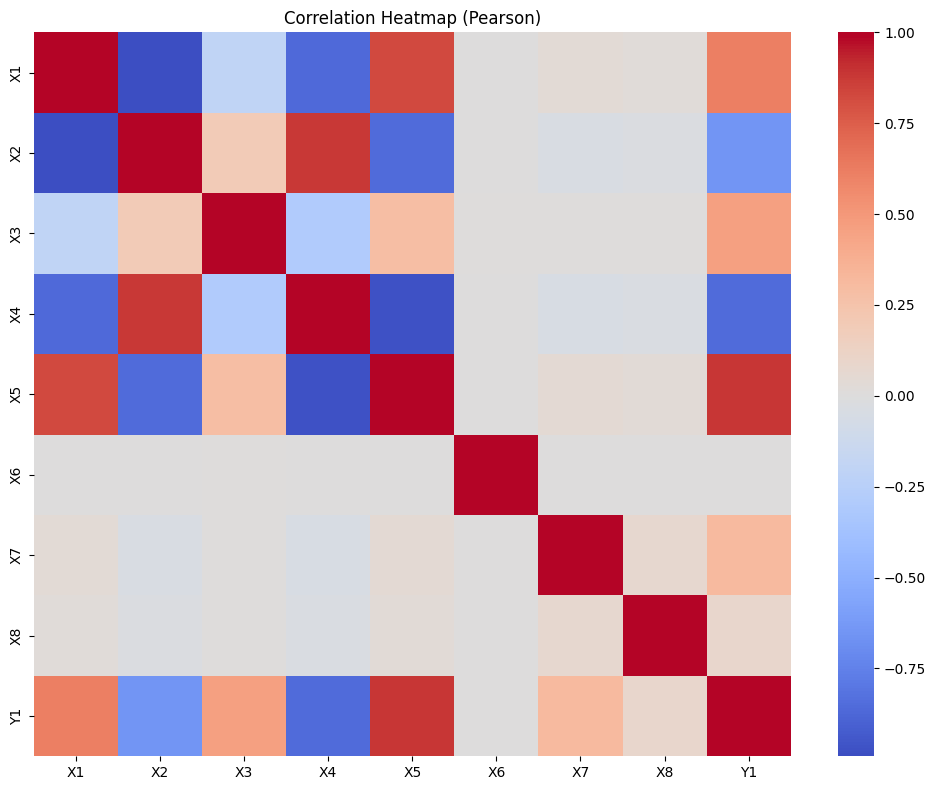


Correlation with Target (Descending):
X5    0.887797
X1    0.616147
X3    0.458827
X7    0.308616
X8    0.087950
X6   -0.000547
X2   -0.654049
X4   -0.858887
Name: Y1, dtype: float64


In [54]:
# === Cell 9: Correlation Analysis === #

# We'll check correlations between numeric features and the target
numeric_features_and_target = [col for col in numeric_columns if col in feature_columns] + [target_column]
correlation_matrix = training_data[numeric_features_and_target].corr(method="pearson")

# A heatmap is a great way to see this visually
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Pearson)")
plt.tight_layout()
plt.show()

# --- Sorted Correlations with Target ---
# To see which features are most correlated with the target
correlations_with_target = correlation_matrix[target_column].drop(labels=[target_column]).sort_values(ascending=False)
print("\nCorrelation with Target (Descending):")
print(correlations_with_target)

In [59]:
# === Cell 10: Basic Cleaning (Imputation) === #

# Create a copy for processing so we don't alter the original data
processed_data = training_data.copy()

# Simple imputation strategy: median for numbers, mode for categories
# Get fresh column lists from our new dataframe
numeric_cols_to_fill = processed_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_to_fill = processed_data.select_dtypes(include=['object','category']).columns.tolist()

# Fill numeric NaNs with the median
processed_data[numeric_cols_to_fill] = processed_data[numeric_cols_to_fill].fillna(processed_data[numeric_cols_to_fill].median())

# Fill categorical NaNs with the mode
for column in categorical_cols_to_fill:
    mode_value = processed_data[column].mode()
    # If mode is not empty, use the first one, otherwise fill with "Unknown"
    fill_value = mode_value.iloc[0] if not mode_value.empty else "Unknown"
    processed_data[column] = processed_data[column].fillna(fill_value)

print("Missing values after imputation:")
print(processed_data.isnull().sum().sum()) 

Missing values after imputation:
0


In [60]:
# === Cell 11: Feature Engineering & Final Prep === #

print("Preparing data for modeling...")

# --- Outlier Removal ---
# Remove extreme outliers from the target variable to stabilize the model.
# Using a 3*IQR range, which is more permissive than the standard 1.5.
Q1 = processed_data[target_column].quantile(0.05)
Q3 = processed_data[target_column].quantile(0.95)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
processed_data = processed_data[(processed_data[target_column] >= lower_bound) & (processed_data[target_column] <= upper_bound)]

print(f"Data shape after outlier removal: {processed_data.shape}")

# --- Feature Engineering Function ---
def create_features(df, base_cols):
    """Generates polynomial and interaction features."""
    df_out = df.copy()
    # Make sure we only use columns that are actually in the dataframe
    valid_cols = [c for c in base_cols if c in df_out.columns]
    
    # Add polynomial features (square, cube)
    for col in valid_cols:
        if df_out[col].std() > 0: # Avoid zero-variance columns
            df_out[f'{col}_sq'] = df_out[col] ** 2
            df_out[f'{col}_cube'] = df_out[col] ** 3
            
    # Add interaction features (e.g., col_A * col_B)
    # Limiting to first 5 valid columns to avoid combinatorial explosion
    for i in range(min(5, len(valid_cols))):
        for j in range(i + 1, min(5, len(valid_cols))):
            col_i = valid_cols[i]
            col_j = valid_cols[j]
            df_out[f'{col_i}_x_{col_j}'] = df_out[col_i] * df_out[col_j]
            
    return df_out

# Get the list of numeric columns to engineer
all_numeric_columns = processed_data.select_dtypes(include=[np.number]).columns.tolist()
feature_numeric_columns = [c for c in all_numeric_columns if c not in [target_column] + id_columns]

# Apply the feature engineering
processed_data_engineered = create_features(processed_data, feature_numeric_columns)

# --- Final Feature & Target Prep ---
# Separate features (X) and target (y)
features = processed_data_engineered.drop(columns=id_columns + [target_column], errors='ignore')
target = processed_data_engineered[target_column].values

# One-hot encode any remaining categorical features
features = pd.get_dummies(features, drop_first=True)
# Ensure all column names are strings for compatibility with all models
features.columns = features.columns.astype(str)

print(f"Final feature matrix shape: {features.shape}")
print(f"Target vector shape: {target.shape}")

Preparing data for modeling...
Data shape after outlier removal: (698, 10)
Final feature matrix shape: (698, 34)
Target vector shape: (698,)


In [61]:
# === Cell 12: Train-Validation Split and Scaling === #

print("Splitting data and scaling...")

# Splitting the data into training (80%) and validation (20%)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    features, target, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {X_train_raw.shape[0]} samples")
print(f"Validation set: {X_val_raw.shape[0]} samples")

# Scale features using RobustScaler
# This is a good choice as it's less sensitive to the outliers we might have missed
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)

print("Data preparation complete!")

Splitting data and scaling...
Training set: 558 samples
Validation set: 140 samples
Data preparation complete!


In [62]:
# === Cell 13: Model Training and Optimization === #

# Helper function for evaluation
def calculate_rmse(y_true, y_pred):
    """Calculates the Root Mean Squared Error."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("Starting model training and optimization...")

# Setting up a grid search for several model types
model_configurations = [
    {'name': 'Ridge', 'model': Ridge, 'params': {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}},
    {'name': 'Lasso', 'model': Lasso, 'params': {'alpha': [0.001, 0.01, 0.1, 1, 10]}},
    {'name': 'ElasticNet', 'model': ElasticNet, 'params': {'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]}},
    {'name': 'GradientBoosting', 'model': GradientBoostingRegressor, 'params': {
        'n_estimators': [100, 200, 500, 1000],
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10, 20]
    }},
    {'name': 'RandomForest', 'model': RandomForestRegressor, 'params': {
        'n_estimators': [100, 300, 500, 1000],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10]
    }},
    {'name': 'ExtraTrees', 'model': ExtraTreesRegressor, 'params': {
        'n_estimators': [100, 300, 500, 1000],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10]
    }},
    {'name': 'MLP', 'model': MLPRegressor, 'params': {
        'hidden_layer_sizes': [(100,), (100, 50), (200, 100), (100, 100, 50)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }}
]

best_model_results = []

# Loop through each model and its parameter grid
for model_config in model_configurations:
    print(f"Optimizing {model_config['name']}...")
    
    param_names = list(model_config['params'].keys())
    param_values = list(model_config['params'].values())
    
    best_score = float('inf')
    best_model = None
    best_params = None
    
    # Manual grid search
    for param_combo in product(*param_values):
        params = dict(zip(param_names, param_combo))
        
        try:
            # Handle linear models
            if model_config['name'] in ['Ridge', 'Lasso', 'ElasticNet']:
                model = model_config['model'](**params, max_iter=10000)
                model.fit(X_train_scaled, y_train)
                val_pred = model.predict(X_val_scaled)
            # Handle tree-based and NN models
            else:
                model = model_config['model'](**params, random_state=42)
                if model_config['name'] == 'MLP':
                    model.set_params(max_iter=1000, early_stopping=True)
                
                # Use scaled data for MLP, raw (unscaled) for tree ensembles
                if model_config['name'] in ['GradientBoosting', 'RandomForest', 'ExtraTrees']:
                    model.fit(X_train_raw, y_train)
                    val_pred = model.predict(X_val_raw)
                else: # MLP
                    model.fit(X_train_scaled, y_train)
                    val_pred = model.predict(X_val_scaled)
            
            validation_rmse = calculate_rmse(y_val, val_pred)
            
            # If this model is better, save it
            if validation_rmse < best_score:
                best_score = validation_rmse
                best_model = model
                best_params = params
                
        except Exception as e:
            # Skip if a parameter combination fails
            continue
            
    # Store the best performing model of this type
    if best_model is not None:
        best_model_results.append({
            'name': model_config['name'],
            'model': best_model,
            'rmse': best_score,
            'params': best_params,
            # Track if the model used scaled data
            'scaled': model_config['name'] in ['Ridge', 'Lasso', 'ElasticNet', 'MLP']
        })
        print(f"  Best RMSE: {best_score:.6f} | Params: {best_params}")

# Sort the models by their validation RMSE
best_model_results.sort(key=lambda x: x['rmse'])

print("\n--- Top 5 Models on Validation Set ---")
for i, m in enumerate(best_model_results[:5], 1):
    print(f"{i}. {m['name']:20s} | RMSE: {m['rmse']:.6f}")

Starting model training and optimization...
Optimizing Ridge...
  Best RMSE: 2.136440 | Params: {'alpha': 0.01}
Optimizing Lasso...
  Best RMSE: 2.201527 | Params: {'alpha': 0.001}
Optimizing ElasticNet...
  Best RMSE: 2.649418 | Params: {'alpha': 0.01, 'l1_ratio': 0.9}
Optimizing GradientBoosting...
  Best RMSE: 0.401172 | Params: {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 5}
Optimizing RandomForest...
  Best RMSE: 0.524830 | Params: {'n_estimators': 1000, 'max_depth': 20, 'min_samples_split': 2}
Optimizing ExtraTrees...
  Best RMSE: 0.522112 | Params: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5}
Optimizing MLP...
  Best RMSE: 0.546730 | Params: {'hidden_layer_sizes': (100, 100, 50), 'alpha': 0.001, 'learning_rate_init': 0.01}

--- Top 5 Models on Validation Set ---
1. GradientBoosting     | RMSE: 0.401172
2. ExtraTrees           | RMSE: 0.522112
3. RandomForest         | RMSE: 0.524830
4. MLP                  | RMSE: 0.546730


In [ ]:
# === Cell 14: Ensemble Creation === #

print("Creating ensemble from top models...")

# Let's try ensembling the top 5 models
top_n_models = best_model_results[:5]

# Stack their validation predictions
validation_predictions_for_ensemble = []
for model_result in top_n_models:
    if model_result['scaled']:
        pred = model_result['model'].predict(X_val_scaled)
    else:
        pred = model_result['model'].predict(X_val_raw)
    validation_predictions_for_ensemble.append(pred)

# Transpose to (n_samples, n_models)
validation_predictions_for_ensemble = np.array(validation_predictions_for_ensemble).T

# Define an objective function for the optimizer
def calculate_ensemble_rmse(weights, preds, y_true):
    """Calculates RMSE for a weighted average of predictions."""
    # Ensure weights are positive and sum to 1
    weights = np.abs(weights) / np.sum(np.abs(weights))
    ensemble_pred = np.dot(preds, weights)
    return calculate_rmse(y_true, ensemble_pred)

# Start with equal weights
initial_weights = np.ones(len(top_n_models)) / len(top_n_models)

# Run the optimizer to find the best weights
optimization_result = minimize(
    calculate_ensemble_rmse, 
    initial_weights, 
    args=(validation_predictions_for_ensemble, y_val),
    method='Nelder-Mead', # A simple, robust optimization method
    options={'maxiter': 1000}
)

# Get the final, normalized weights
optimal_weights = np.abs(optimization_result.x) / np.sum(np.abs(optimization_result.x))

# Calculate the final ensemble's score
final_validation_prediction = np.dot(validation_predictions_for_ensemble, optimal_weights)
final_validation_rmse = calculate_rmse(y_val, final_validation_prediction)

print(f"\nFinal Validation RMSE: {final_validation_rmse:.6f}")
print(f"\nEnsemble Weights:")
for m, w in zip(top_n_models, optimal_weights):
    print(f"  {m['name']:20s}: {w:.4f}")

Creating ensemble from top models...

Final Validation RMSE: 0.395199

Ensemble Weights:
  GradientBoosting    : 0.8164
  ExtraTrees          : 0.0756
  RandomForest        : 0.0000
  MLP                 : 0.1079
  Ridge               : 0.0000


In [64]:
# === Cell 12: Train-validation split and scaling ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

print("Splitting data and scaling...")

# 80/20 split
X_train, X_val, y_train, y_val = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

# Scale features using RobustScaler (as in successful code)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Data preparation complete!")
print("Ready for model training and optimization.")

Splitting data and scaling...
Training set: 558 samples
Validation set: 140 samples
Data preparation complete!
Ready for model training and optimization.


In [65]:
# === Cell 13: Model training and optimization ===
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from itertools import product
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("Starting model training and optimization...")

# Model configurations (from successful code)
model_configs = [
    {'name': 'Ridge', 'model': Ridge, 'params': {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}},
    {'name': 'Lasso', 'model': Lasso, 'params': {'alpha': [0.001, 0.01, 0.1, 1, 10]}},
    {'name': 'ElasticNet', 'model': ElasticNet, 'params': {'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.1, 0.5, 0.9]}},
    {'name': 'GradientBoosting', 'model': GradientBoostingRegressor, 'params': {
        'n_estimators': [100, 200, 500, 1000],
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10, 20]
    }},
    {'name': 'RandomForest', 'model': RandomForestRegressor, 'params': {
        'n_estimators': [100, 300, 500, 1000],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10]
    }},
    {'name': 'ExtraTrees', 'model': ExtraTreesRegressor, 'params': {
        'n_estimators': [100, 300, 500, 1000],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10]
    }},
    {'name': 'MLP', 'model': MLPRegressor, 'params': {
        'hidden_layer_sizes': [(100,), (100, 50), (200, 100), (100, 100, 50)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }}
]

best_models = []

for config in model_configs:
    print(f"Optimizing {config['name']}...")
    
    param_names = list(config['params'].keys())
    param_values = list(config['params'].values())
    
    best_score = float('inf')
    best_model = None
    best_params = None
    
    # Grid search
    for param_combo in product(*param_values):
        params = dict(zip(param_names, param_combo))
        
        try:
            if config['name'] in ['Ridge', 'Lasso', 'ElasticNet']:
                model = config['model'](**params, max_iter=10000)
                model.fit(X_train_scaled, y_train)
                val_pred = model.predict(X_val_scaled)
            else:
                model = config['model'](**params, random_state=42)
                if config['name'] == 'MLP':
                    model.set_params(max_iter=1000, early_stopping=True)
                model.fit(X_train if config['name'] in ['GradientBoosting', 'RandomForest', 'ExtraTrees'] else X_train_scaled, y_train)
                val_pred = model.predict(X_val if config['name'] in ['GradientBoosting', 'RandomForest', 'ExtraTrees'] else X_val_scaled)
            
            val_rmse = rmse(y_val, val_pred)
            
            if val_rmse < best_score:
                best_score = val_rmse
                best_model = model
                best_params = params
                
        except Exception as e:
            continue
    
    if best_model is not None:
        best_models.append({
            'name': config['name'],
            'model': best_model,
            'rmse': best_score,
            'params': best_params,
            'scaled': config['name'] in ['Ridge', 'Lasso', 'ElasticNet', 'MLP']
        })
        print(f"  Best RMSE: {best_score:.6f} | Params: {best_params}")

# Sort by performance
best_models.sort(key=lambda x: x['rmse'])

print("\nTop 5 models on validation set:")
for i, m in enumerate(best_models[:5], 1):
    print(f"{i}. {m['name']:20s} | RMSE: {m['rmse']:.6f}")

Starting model training and optimization...
Optimizing Ridge...
  Best RMSE: 2.136440 | Params: {'alpha': 0.01}
Optimizing Lasso...
  Best RMSE: 2.201527 | Params: {'alpha': 0.001}
Optimizing ElasticNet...
  Best RMSE: 2.649418 | Params: {'alpha': 0.01, 'l1_ratio': 0.9}
Optimizing GradientBoosting...
  Best RMSE: 0.401172 | Params: {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 5}
Optimizing RandomForest...
  Best RMSE: 0.524830 | Params: {'n_estimators': 1000, 'max_depth': 20, 'min_samples_split': 2}
Optimizing ExtraTrees...
  Best RMSE: 0.522112 | Params: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5}
Optimizing MLP...
  Best RMSE: 0.546730 | Params: {'hidden_layer_sizes': (100, 100, 50), 'alpha': 0.001, 'learning_rate_init': 0.01}

Top 5 models on validation set:
1. GradientBoosting     | RMSE: 0.401172
2. ExtraTrees           | RMSE: 0.522112
3. RandomForest         | RMSE: 0.524830
4. MLP                  | RMSE: 0.546730
5. Ridg

In [66]:
# === Cell 14: Ensemble creation ===
from scipy.optimize import minimize

print("Creating ensemble from top models...")

# Use top 5 models for ensemble
top_models = best_models[:5]

# Get predictions from each model
val_preds_ensemble = []
for m in top_models:
    if m['scaled']:
        pred = m['model'].predict(X_val_scaled)
    else:
        pred = m['model'].predict(X_val)
    val_preds_ensemble.append(pred)

val_preds_ensemble = np.array(val_preds_ensemble).T

# Optimize ensemble weights
def ensemble_rmse(weights, preds, y_true):
    weights = np.abs(weights) / np.sum(np.abs(weights))
    ensemble_pred = np.dot(preds, weights)
    return rmse(y_true, ensemble_pred)

initial_weights = np.ones(len(top_models)) / len(top_models)
result = minimize(
    ensemble_rmse, 
    initial_weights, 
    args=(val_preds_ensemble, y_val),
    method='Nelder-Mead',
    options={'maxiter': 1000}
)

optimal_weights = np.abs(result.x) / np.sum(np.abs(result.x))

ensemble_pred = np.dot(val_preds_ensemble, optimal_weights)
final_val_rmse = rmse(y_val, ensemble_pred)

print(f"Final Validation RMSE: {final_val_rmse:.6f}")
print(f"\nEnsemble weights:")
for m, w in zip(top_models, optimal_weights):
    print(f"  {m['name']:20s}: {w:.4f}")

Creating ensemble from top models...
Final Validation RMSE: 0.395199

Ensemble weights:
  GradientBoosting    : 0.8164
  ExtraTrees          : 0.0756
  RandomForest        : 0.0000
  MLP                 : 0.1079
  Ridge               : 0.0000


In [67]:
# === Cell 15: Load and Process Test Data === #

print("Processing test data...")

# Update this path to your test data location
TEST_FILE_PATH = "test_dataset.xlsx"  # <<< CHANGE THIS TO YOUR TEST FILE

if TEST_FILE_PATH.lower().endswith(".xlsx"):
    test_data = pd.read_excel(TEST_FILE_PATH)
else:
    test_data = pd.read_csv(TEST_FILE_PATH)

print(f"Test data loaded: {test_data.shape}")

# --- Find ID Column ---
ID_COLUMN = None
for c in test_data.columns:
    if str(c).strip().upper() == 'ID':
        ID_COLUMN = c
        break
if ID_COLUMN is None:
    ID_COLUMN = 'ID' # Assume 'ID' if not found

test_ids = test_data[ID_COLUMN].values

# --- Preprocess Test Data ---
# We must use the same statistics (median/mode) from the *original training data*
test_numeric_columns = [c for c in feature_numeric_columns if c in test_data.columns]
test_categorical_columns = [c for c in categorical_cols_to_fill if c in test_data.columns and c != target_column]

# Get medians/modes from the *original* (pre-engineering) training data
training_medians = training_data[feature_numeric_columns].median()
training_modes = {}
for c in categorical_cols_to_fill:
    m = training_data[c].mode()
    training_modes[c] = m.iloc[0] if not m.empty else "Unknown"

# Apply imputation
test_data[test_numeric_columns] = test_data[test_numeric_columns].fillna(training_medians[test_numeric_columns])
for c in test_categorical_columns:
    if c in training_modes:
        test_data[c] = test_data[c].fillna(training_modes[c])

# Apply the *exact same* feature engineering
test_data_engineered = create_features(test_data, feature_numeric_columns)

# Prepare test features
test_features = test_data_engineered.drop(columns=[c for c in [ID_COLUMN] + id_columns if c in test_data_engineered.columns], errors='ignore')
test_features = pd.get_dummies(test_features, drop_first=True)
test_features.columns = test_features.columns.astype(str)

# Align test columns with training columns
# This adds any columns that were in training (e.g., from one-hot) but not in test,
# and removes any new columns from test that weren't in training.
test_features = test_features.reindex(columns=features.columns, fill_value=0)

# Scale test data using the *same scaler* fitted on the training data
test_features_scaled = scaler.transform(test_features)

print(f"Test features prepared: {test_features.shape}")

Processing test data...
Test data loaded: (70, 9)
Test features prepared: (70, 34)


In [68]:
# === Cell 16: Generate Predictions and Create Submission === #

print("Generating final predictions...")

# Generate predictions from each of our top models
test_predictions_from_models = []
for model_result in top_n_models:
    if model_result['scaled']:
        pred = model_result['model'].predict(test_features_scaled)
    else:
        pred = model_result['model'].predict(test_features)
    test_predictions_from_models.append(pred)

# Transpose and apply the optimized weights
test_predictions_from_models = np.array(test_predictions_from_models).T
final_test_predictions = np.dot(test_predictions_from_models, optimal_weights)

# --- Post-processing ---
# Clip predictions to a reasonable range (e.g., 1st/99th percentile of training target)
# This prevents the model from predicting nonsensical extreme values
target_min_clip, target_max_clip = np.percentile(target, [1, 99])
final_test_predictions = np.clip(final_test_predictions, target_min_clip, target_max_clip)

print(f"Predictions range: [{final_test_predictions.min():.2f}, {final_test_predictions.max():.2f}]")
print(f"Training target range: [{target.min():.2f}, {target.max():.2f}]")

# --- Create Submission File ---
submission_file = pd.DataFrame({
    'ID': test_ids,
    'Heating_Load': final_test_predictions # Using the column name required by the competition
})

# Sort by ID just in case
submission_file = submission_file.sort_values('ID').reset_index(drop=True)
submission_file.to_csv('student_submission.csv', index=False)

print(f"\nSubmission saved: student_submission.csv")
print(f"Final Validation RMSE was: {final_validation_rmse:.6f}")
print("\nReady to upload!")

Generating final predictions...
Predictions range: [13.90, 42.09]
Training target range: [6.01, 43.10]

Submission saved: student_submission.csv
Final Validation RMSE was: 0.395199

Ready to upload!
